In [53]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
# Load the data from the CSV file
columns=["T_healty", "T_covid", "RR_healty", "RR_covid"]
data = pd.read_csv("../data/A2Q2.csv",header=None)
data.columns = columns

<Axes: title={'center': 'Histgrom of RR values'}, xlabel='Respiration Rate', ylabel='Frequency'>

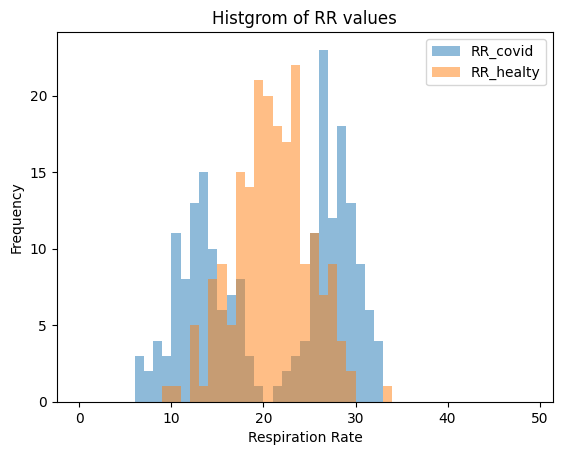

In [3]:
data["RR_covid"].plot.hist(
    bins=np.array(range(0,50,1)),
    alpha=0.5,
    legend=True,
    )
data["RR_healty"].plot.hist(
    bins=np.array(range(0,50,1)),
    alpha=0.5,
    legend=True,
    xlabel="Respiration Rate",
    title="Histgrom of RR values"
    )

<Axes: title={'center': 'Histgrom of T values'}, xlabel='Temperature', ylabel='Frequency'>

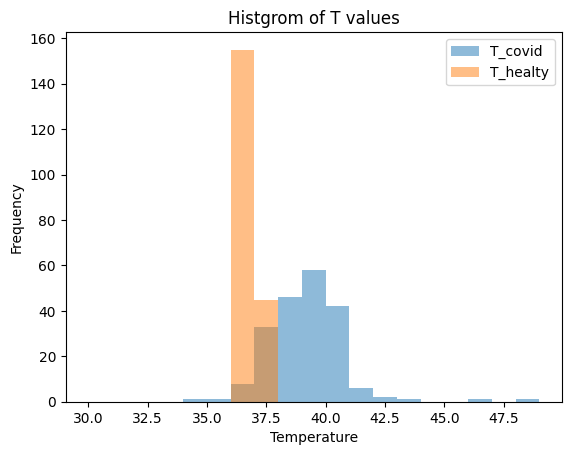

In [4]:
data["T_covid"].plot.hist(
    bins=np.array(range(30,50,1)),
    alpha=0.5,
    legend=True,
    )
data["T_healty"].plot.hist(
    bins=np.array(range(30,50,1)),
    alpha=0.5,
    legend=True,
    xlabel="Temperature",
    title="Histgrom of T values"
    )

# Question 1

In [5]:
# Calculate mean vectors for each class
mean_vector_healthy = np.array([data["T_healty"].mean(), data["RR_healty"].mean()])
mean_vector_covid = np.array([data["T_covid"].mean(), data["RR_covid"].mean()])

# Calculate covariance matrices for each class
cov_matrix_healthy = np.cov(data["T_healty"], data["RR_healty"], ddof=1)
cov_matrix_covid = np.cov(data["T_covid"], data["RR_covid"], ddof=1)

# Print the results
print("Mean Healthy Vector:", mean_vector_healthy)
print("Mean COVID Vector:", mean_vector_covid)
print("\nCovariance Healthy matrix:")
print(cov_matrix_healthy)
print("\nCovariance COVID matrix:")
print(cov_matrix_covid)

Mean Healthy Vector: [36.78693378 21.01158943]
Mean COVID Vector: [39.17925122 20.92543238]

Covariance Healthy matrix:
[[ 6.98155852e-02 -1.52298917e-02]
 [-1.52298917e-02  1.68698681e+01]]

Covariance COVID matrix:
[[ 2.38247517 -0.76294817]
 [-0.76294817 60.74945047]]


# Question 2

In [6]:
# obseravation
t = 37.5
rr = 23
observation = np.array([t,rr])

# Likelihoods
likelihood_healthy = multivariate_normal(mean=mean_vector_healthy, cov=cov_matrix_healthy).pdf(observation)
likelihood_covid = multivariate_normal(mean=mean_vector_covid, cov=cov_matrix_covid).pdf(observation)

# Priors
prior_healthy = 0.9
prior_covid = 0.1

# Evidence 
w_sum_p = (likelihood_healthy * prior_healthy) + (likelihood_covid * prior_covid)
posterior_probability = (likelihood_healthy * prior_healthy) / w_sum_p
print(f"Posterior probability that the patient is healthy given T={t} and RR={rr}: {posterior_probability}")

Posterior probability that the patient is healthy given T=37.5 and RR=23: 0.8076043018136831


In [7]:
# init
rr = 23
prior_covid = 0.1
prior_healthy = 0.9
t_max = max(data["T_healty"].max(), data["T_covid"].max())
t_min = min(data["T_healty"].min(), data["T_covid"].min())
t_curr = t_min
mvn_covid = multivariate_normal(mean=mean_vector_covid, cov=cov_matrix_covid)
mvn_healthy = multivariate_normal(mean=mean_vector_healthy, cov=cov_matrix_healthy)
t_postirior_covid = []
temperatures = []

# Calculate positirier values for varying temperature values
while t_curr < t_max:
    observation = np.array([t_curr, rr])
    likelihood_covid = mvn_covid.pdf(observation)
    likelihood_healthy = mvn_healthy.pdf(observation) 
    posterior_covid = likelihood_covid * prior_covid / ((likelihood_covid * prior_covid) + (likelihood_healthy * prior_healthy))
    t_postirior_covid.append(posterior_covid)
    temperatures.append(t_curr)
    t_curr += 0.01


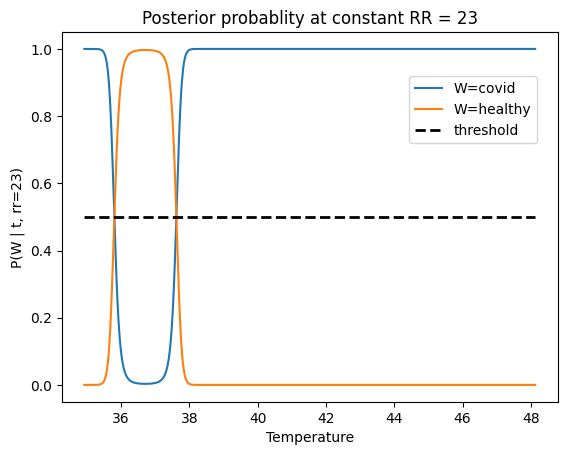

In [8]:
posterior_df = pd.DataFrame(
    {
        "W=covid":t_postirior_covid,
        # "temperature":temperatures
    },
    index=temperatures
)
posterior_df["W=healthy"] = 1 - posterior_df["W=covid"]


posterior_df.plot(
    title="Posterior probablity at constant RR = 23",
    xlabel="Temperature",
    ylabel="P(W | t, rr=23)"
)
plt.plot([t_min, t_max], [0.5, 0.5], color='black', lw=2, linestyle='--', label="threshold")
plt.legend(loc=(0.7,0.7))

In [9]:
posterior_df[(posterior_df["W=covid"] > 0.5) & (posterior_df["W=covid"] < 0.55)]

,W=covid,W=healthy
35.79644,0.527145,0.472855
37.62644,0.514903,0.485097
37.63644,0.546686,0.453314


# Question 3

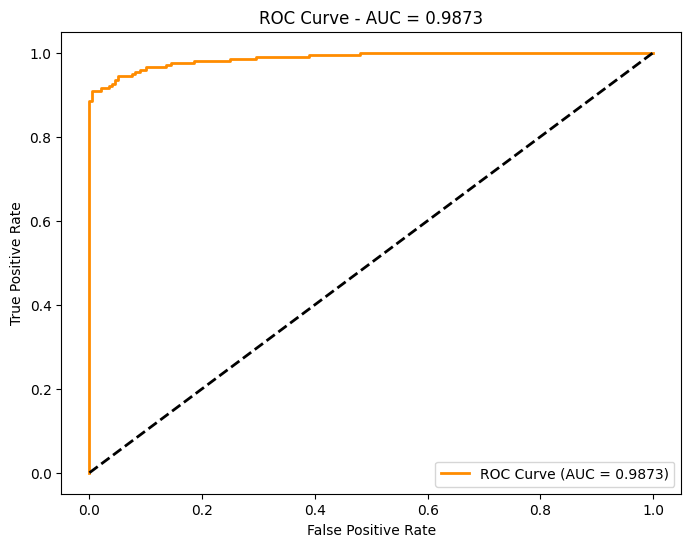

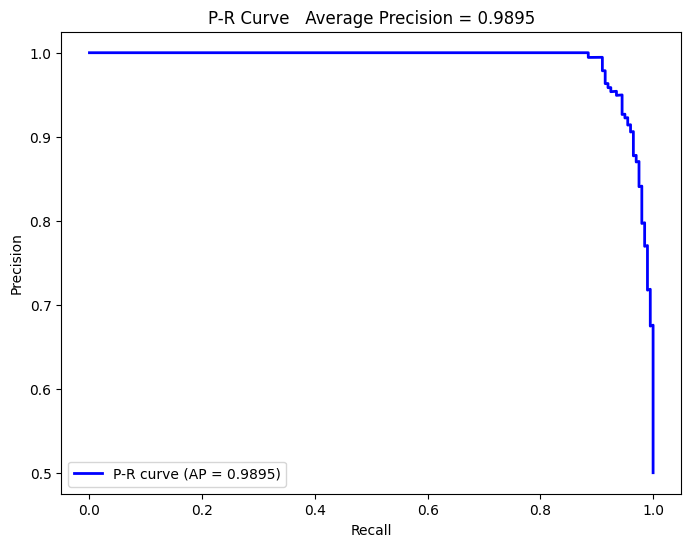

In [10]:
# build dataset
dataset_covid = pd.DataFrame(data[["T_covid","RR_covid"]])
dataset_covid.columns = ["t","rr"]
dataset_covid["label"] = 1

dataset_healthy = pd.DataFrame(data[["T_healty","RR_healty"]])
dataset_healthy.columns = ["t","rr"]
dataset_healthy["label"] = 0

dataset = pd.concat(
    [dataset_covid,dataset_healthy],
    axis=0
)


# make predictions
classifications = []

mvn_covid = multivariate_normal(mean=mean_vector_covid, cov=cov_matrix_covid)
mvn_healthy = multivariate_normal(mean=mean_vector_healthy, cov=cov_matrix_healthy)

for row in dataset.iterrows():
    observation = np.array([row[1]['t'], row[1]['rr']])
    likelihood_covid = mvn_covid.pdf(observation)
    likelihood_healthy = mvn_healthy.pdf(observation) 
    posterior_covid = likelihood_covid * prior_covid / ((likelihood_covid * prior_covid) + (likelihood_healthy * prior_healthy))
    classifications.append(posterior_covid)

dataset["prediction"] = classifications

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(dataset["label"], dataset["prediction"])
roc_auc = auc(fpr, tpr)

# Calculate P-R curve
precision, recall, thresholds_pr = precision_recall_curve(dataset["label"], dataset["prediction"])
average_precision = average_precision_score(dataset["label"], dataset["prediction"])

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC Curve (AUC = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - AUC = {roc_auc:0.4f}')
plt.legend(loc='lower right')
plt.show()

# Plot P-R curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='P-R curve (AP = %0.4f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'P-R Curve   Average Precision = {average_precision:0.4f}')
plt.legend(loc='lower left')
plt.show()


# Question 4

In [46]:
# permutate to get the metrics for varying thresholds
fpr_list = []
precison_list = []
sensitivity_list = []
confusion_matrix_list = []

for threshold in np.array(range(0,1000000,1))/1000000:
    y_pred = (dataset['prediction'] > threshold).astype(int)
    confusion = confusion_matrix(dataset['label'], y_pred)
    tn, fp, fn, tp = confusion.ravel()
    fpr = fp / (tn+fp)
    sensitivity = tp/(tp+fn)
    precision = tp/(tp+fp)
    fpr_list.append(fpr)
    sensitivity_list.append(sensitivity)
    precison_list.append(precision)
    confusion_matrix_list.append(confusion)


    

In [47]:
# filter the results
metrics_df = pd.DataFrame(
    {
        "threshold": np.array(range(0,1000000,1))/1000000,
        "fpr": fpr_list,
        "sensitivity": sensitivity_list,
        "precision": precison_list,
    },
    index=range(1000000)
).set_index("threshold")

acceptable_values = metrics_df[metrics_df['fpr']<0.15]
min_threshold = min(acceptable_values.index)
max_senitivity = max(acceptable_values['sensitivity'])
max_precision = max(acceptable_values["precision"])
min_precision = min(acceptable_values["precision"]) 


In [48]:
print(f"Threshold: {min_threshold}")
print(f"max senitivity: {max_senitivity}")
print(f"max precision: {max_precision}")
print(f"min precision: {min_precision}")

Threshold: 0.016224
max senitivity: 0.975
max precision: 1.0
min precision: 0.8699551569506726


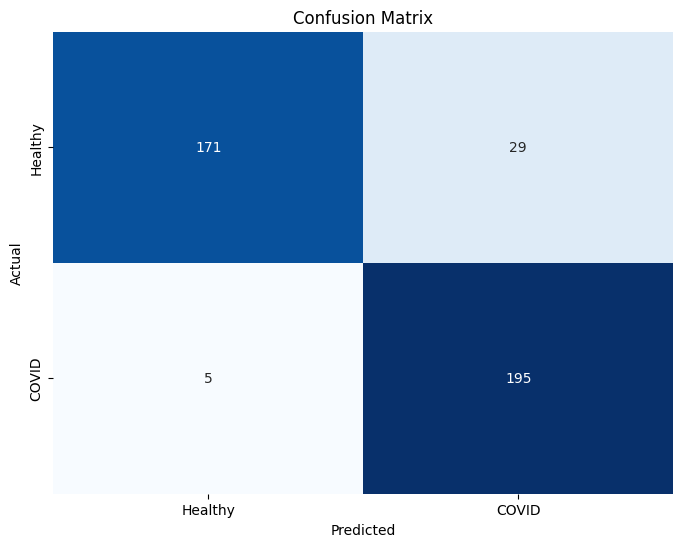

In [55]:
# get the confusion matrix
y_pred = (dataset['prediction'] > min_threshold).astype(int)
confusion = confusion_matrix(dataset['label'], y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Healthy', 'COVID'], yticklabels=['Healthy', 'COVID'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


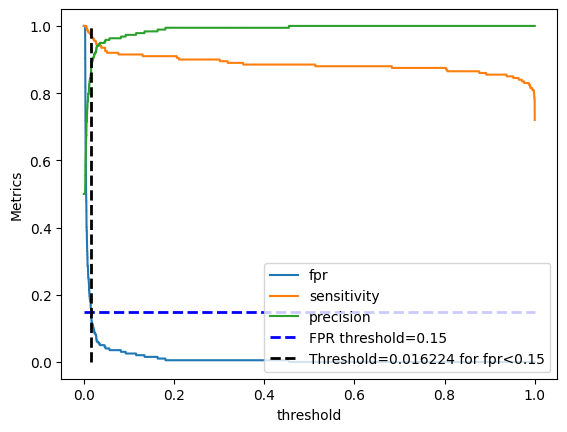

In [49]:
metrics_df.plot()
plt.plot([0, 1], [0.15, 0.15], color='blue', lw=2, linestyle='--', label="FPR threshold=0.15")
plt.plot([min_threshold, min_threshold], [0, 1], color='black', lw=2, linestyle='--', label=f"Threshold={min_threshold} for fpr<0.15")
plt.legend(loc='lower right')
plt.ylabel("Metrics")
plt.show()

# Question 5

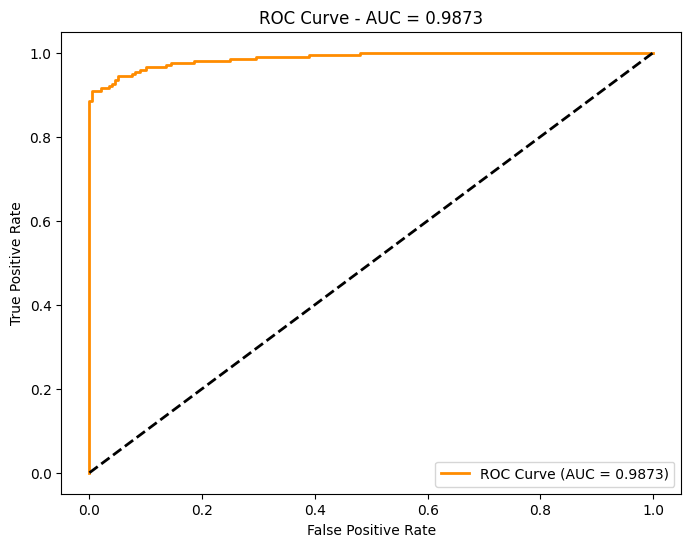

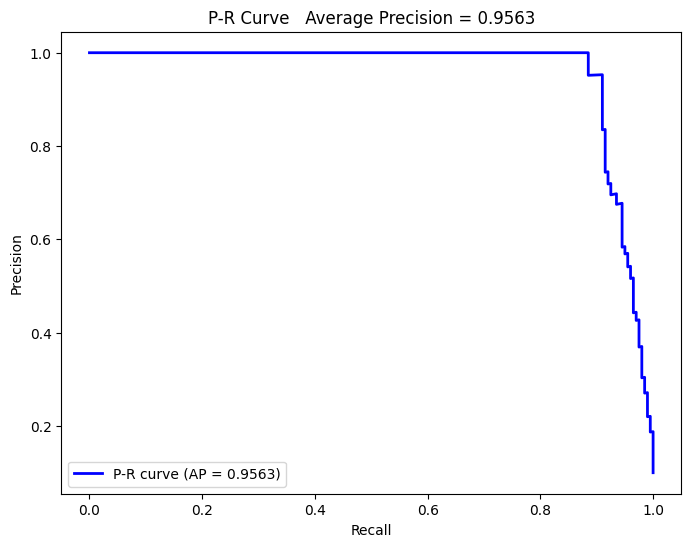

In [15]:
# create new dataset
copy_healthy = 9
copy_covid = 1
dataset_list = [dataset_healthy for _ in range(copy_healthy)] + [dataset_covid for _ in range(copy_covid)]
new_datset = pd.concat(dataset_list)

# Make predictions
classifications = []

mvn_covid = multivariate_normal(mean=mean_vector_covid, cov=cov_matrix_covid)
mvn_healthy = multivariate_normal(mean=mean_vector_healthy, cov=cov_matrix_healthy)

for row in new_datset.iterrows():
    observation = np.array([row[1]['t'], row[1]['rr']])
    likelihood_covid = mvn_covid.pdf(observation)
    likelihood_healthy = mvn_healthy.pdf(observation) 
    posterior_covid = likelihood_covid * prior_covid / ((likelihood_covid * prior_covid) + (likelihood_healthy * prior_healthy))
    classifications.append(posterior_covid)

new_datset["prediction"] = classifications

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(new_datset["label"], new_datset["prediction"])
roc_auc = auc(fpr, tpr)

# Calculate P-R curve
precision, recall, thresholds_pr = precision_recall_curve(new_datset["label"], new_datset["prediction"])
average_precision = average_precision_score(new_datset["label"], new_datset["prediction"])

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC Curve (AUC = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - AUC = {roc_auc:0.4f}')
plt.legend(loc='lower right')
plt.show()

# Plot P-R curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='P-R curve (AP = %0.4f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'P-R Curve   Average Precision = {average_precision:0.4f}')
plt.legend(loc='lower left')
plt.show()

# Question 6

false negative rate


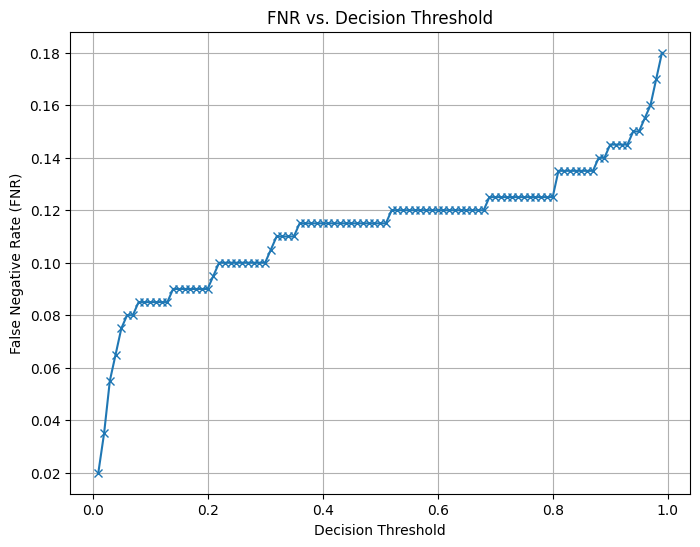

In [16]:
# Create an empty list to store FNR values for different thresholds
fnr_values = []

decision_threshold = np.array(range(1,100,1))/100 

# Calculate FNR for each threshold
for threshold in decision_threshold:
    predicted_labels = (dataset['prediction'] >= threshold).astype(int)
    confusion = confusion_matrix(dataset['label'], predicted_labels)
    tn, fp, fn, tp = confusion.ravel()
    fnr = fn / (fn + tp)
    fnr_values.append(fnr)

# Create a line plot to visualize FNR vs. Threshold
plt.figure(figsize=(8, 6))
plt.plot(decision_threshold, fnr_values, marker='x', linestyle='-')
plt.xlabel('Decision Threshold')
plt.ylabel('False Negative Rate (FNR)')
plt.title('FNR vs. Decision Threshold')
plt.grid()
plt.show()

# Question 7

In [17]:
# init
k_values = [1, 5, 15, 25]
error_rates = []
knns = []

# Create x, y
x = dataset[['t','rr']].to_numpy()
y = dataset['label'].to_numpy()

# train knns
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x, y)
    y_pred = knn.predict(x)
    accuracy = accuracy_score(y, y_pred)
    error_rate = 1 - accuracy
    error_rates.append(error_rate)
    knns.append(knn)

# Print the error rates for different K values
for k, error_rate in zip(k_values, error_rates):
    print(f"K = {k}: Apparent Error Rate = {error_rate:.4f}")

# Find the best performing K based on the lowest apparent error rate
best_k = k_values[error_rates.index(min(error_rates))]
print(f"The best performing K is K = {best_k} with an apparent error rate of {min(error_rates):.4f}")

K = 1: Apparent Error Rate = 0.0000
K = 5: Apparent Error Rate = 0.0600
K = 15: Apparent Error Rate = 0.0775
K = 25: Apparent Error Rate = 0.0850
The best performing K is K = 1 with an apparent error rate of 0.0000


In [18]:
dataset.iloc[0]['t']

40.066609

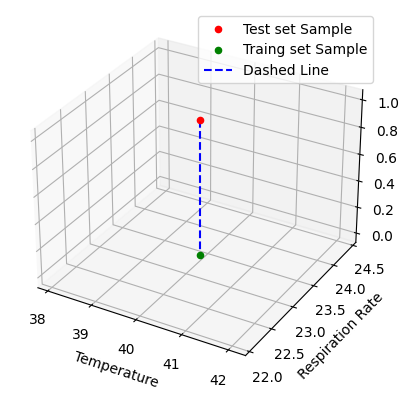

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Define the points
x = [dataset.iloc[0]['t'], dataset.iloc[0]['t']]
y = [dataset.iloc[0]['rr'], dataset.iloc[0]['rr']]
z = [1, 0]
labels = ['Test set Sample', 'Traing set Sample']

# Plot the points
ax.scatter(x[0], y[0], z[0], c='red', marker='o', label=labels[0])
ax.scatter(x[1], y[1], z[1], c='green', marker='o', label=labels[1])

# Connect the points with a dashed line
ax.plot(x, y, z, linestyle='--', color='blue', label='Dashed Line')

# Label the axes
ax.set_xlabel('Temperature')
ax.set_ylabel('Respiration Rate')
# ax.set_zlabel('Actual=0, Predicted =1')

# Set the axis limits
# ax.set_xlim(0, 0.5)
# ax.set_ylim(-0.1, 0.1)
# ax.set_zlim(0, 1.2)

# Add a legend
ax.legend()

plt.show()